In [1]:
# Make plots appear inline, set custom plotting style
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../style/elegant.mplstyle')

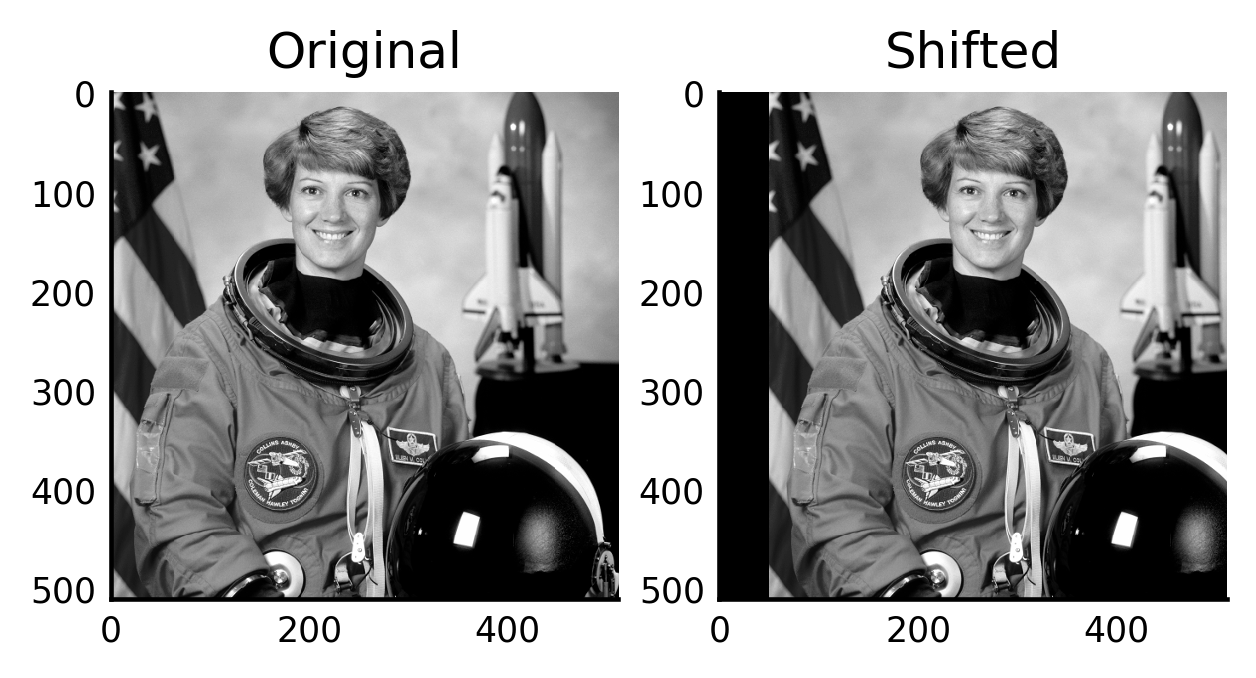

In [2]:
from skimage import data, color
from scipy import ndimage as ndi

astronaut = color.rgb2gray(data.astronaut())
shifted = ndi.shift(astronaut, (0, 50))

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(astronaut)
axes[0].set_title('Original')
axes[1].imshow(shifted)
axes[1].set_title('Shifted');

In [3]:
import numpy as np

def mse(arr1, arr2):
    """Compute the mean squared error between two arrays."""
    return np.mean((arr1 - arr2)**2)

In [4]:
from scipy import optimize

def astronaut_shift_error(shift, image):
    corrected = ndi.shift(image, (0, shift))
    return mse(astronaut, corrected)

res = optimize.minimize(astronaut_shift_error, 0, args=(shifted,),
                        method='Powell')

print(f'The optimal shift for correction is: {res.x}')

The optimal shift for correction is: -49.99997565757095


In [5]:
def downsample2x(image):
    offsets = [((s + 1) % 2) / 2 for s in image.shape]
    slices = [slice(offset, end, 2)
              for offset, end in zip(offsets, image.shape)]
    coords = np.mgrid[slices]
    return ndi.map_coordinates(image, coords, order=1)

In [6]:
def gaussian_pyramid(image, levels=6):
    """Make a Gaussian image pyramid.

    Parameters
    ----------
    image : array of float
        The input image.
    max_layer : int, optional
        The number of levels in the pyramid.

    Returns
    -------
    pyramid : iterator of array of float
        An iterator of Gaussian pyramid levels, starting with the top
        (lowest resolution) level.
    """
    pyramid = [image]

    for level in range(levels - 1):
        blurred = ndi.gaussian_filter(image, sigma=2/3)
        image = downsample2x(image)
        pyramid.append(image)

    return reversed(pyramid)

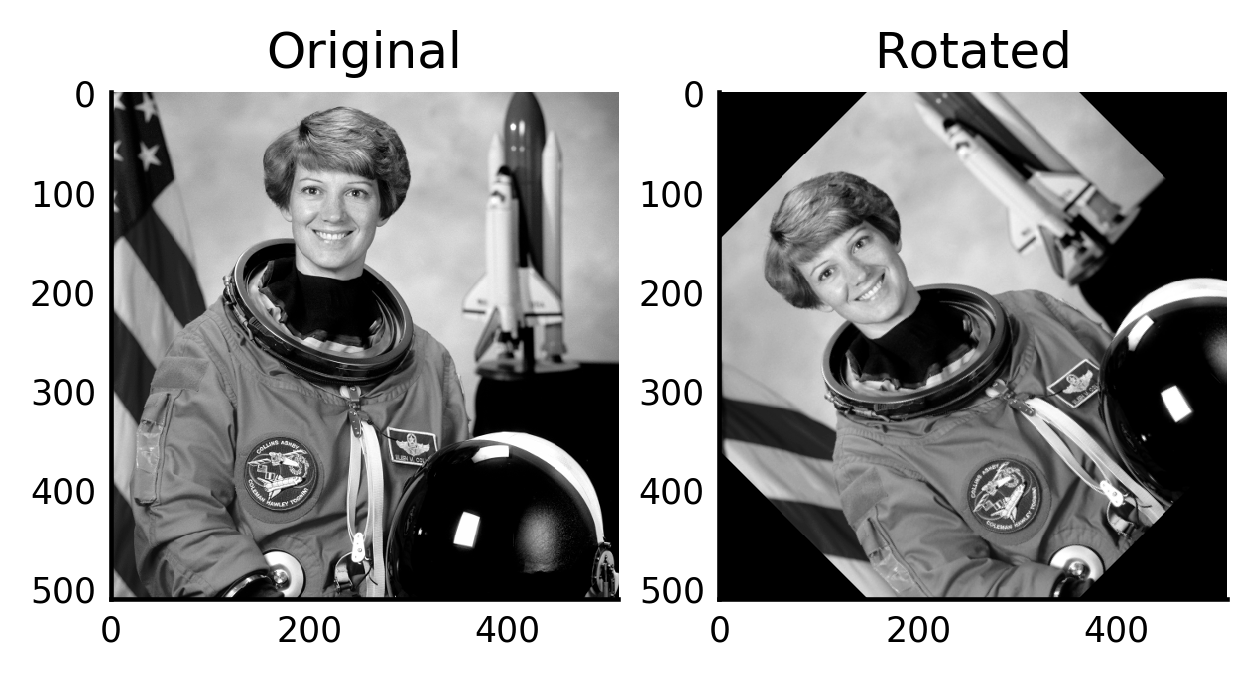

In [7]:
from skimage import transform

def make_rigid_transform(param):
    r, tc, tr = param
    return transform.SimilarityTransform(rotation=r,
                                         translation=(tc, tr))

rotated = transform.rotate(astronaut, 45)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(astronaut)
axes[0].set_title('Original')
axes[1].imshow(rotated)
axes[1].set_title('Rotated');

In [8]:
def cost_mse(param, reference_image, target_image):
    transformation = make_rigid_transform(param)
    transformed = transform.warp(target_image, transformation, order=3)
    return mse(reference_image, transformed)

In [9]:
def align(reference, target, cost=cost_mse, nlevels=7, method='Powell'):
    pyramid_ref = gaussian_pyramid(reference, levels=nlevels)
    pyramid_tgt = gaussian_pyramid(target, levels=nlevels)

    levels = range(nlevels, 0, -1)
    image_pairs = zip(pyramid_ref, pyramid_tgt)

    p = np.zeros(3)

    for n, (ref, tgt) in zip(levels, image_pairs):
        p[1:] *= 2
        if method.upper() == 'BH':
            res = optimize.basinhopping(cost, p,
                                        minimizer_kwargs={'args': (ref, tgt)})
            if n <= 4:  # avoid basin hopping in lower levels
                method = 'Powell'
        else:
            res = optimize.minimize(cost, p, args=(ref, tgt), method='Powell')
        p = res.x
        # print current level, overwriting each time (like a progress bar)
        print(f'Level: {n}, Angle: {np.rad2deg(res.x[0]) :.3}, '
              f'Offset: ({res.x[1] * 2**n :.3}, {res.x[2] * 2**n :.3}), '
              f'Cost: {res.fun :.3}', end='\r')

    print('')  # newline when alignment complete
    return make_rigid_transform(p)

evel: 4, Angle: -50.0, Offset: (-2.05e+02, 5.67e+02), Cost: 0.0361Level: 2, Angle: -50.0, Offset: (-2.08e+02, 5.73e+02), Cost: 0.0379


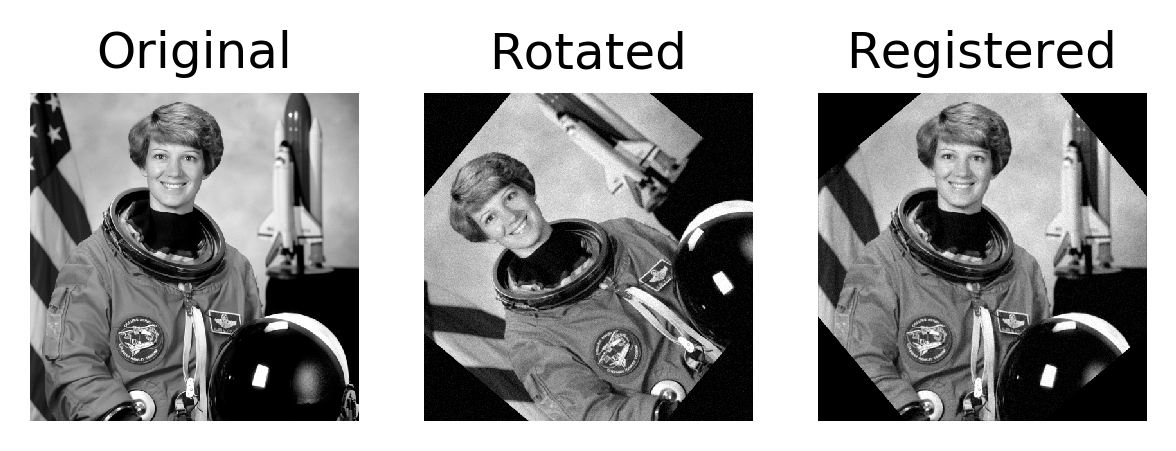

In [10]:
from skimage import util

theta = 50
rotated = transform.rotate(astronaut, theta)
rotated = util.random_noise(rotated, mode='gaussian',
                            seed=0, mean=0, var=1e-3)

tf = align(astronaut, rotated, nlevels=8, method='BH')
corrected = transform.warp(rotated, tf, order=3)

f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(astronaut)
ax0.set_title('Original')
ax1.imshow(rotated)
ax1.set_title('Rotated')
ax2.imshow(corrected)
ax2.set_title('Registered')
for ax in (ax0, ax1, ax2):
    ax.axis('off')